In [ ]:
pip install tensorflow matplotlib pillow


Iteration 0, Loss: 169042320.0000
Iteration 100, Loss: 2534939.0000
Iteration 200, Loss: 1667244.1250
Iteration 300, Loss: 1365159.2500
Iteration 400, Loss: 1208278.3750


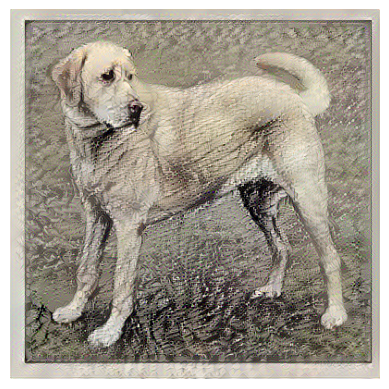

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import PIL.Image

# Function to load and preprocess the image
def load_and_process_img(path_to_img):
    img = kp_image.load_img(path_to_img, target_size=(400, 400))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess the image
def deprocess_img(processed_img):
    x = processed_img.copy()
    x = x.reshape((400, 400, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load content and style images
content_path = 'c.png'
style_path = 'cj.jpg'

content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)

# Display images (optional)
def show_img(img):
    img = deprocess_img(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Load VGG19 and define layers for style/content
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

style_layers = ['block1_conv1', 'block2_conv1',
                'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    return Model(inputs=vgg.input, outputs=outputs)

def gram_matrix(tensor):
    x = tf.squeeze(tensor)
    x = tf.reshape(x, [-1, x.shape[-1]])
    return tf.matmul(x, x, transpose_a=True) / tf.cast(tf.shape(x)[0], tf.float32)

def get_feature_representations(model, content_path, style_path):
    content = load_and_process_img(content_path)
    style = load_and_process_img(style_path)

    style_outputs = model(style)
    content_outputs = model(content)

    style_features = [gram_matrix(output) for output in style_outputs[:num_style_layers]]
    content_features = [output for output in content_outputs[num_style_layers:]]

    return style_features, content_features

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += tf.reduce_mean(tf.square(target_style - gram_matrix(comb_style)))

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += tf.reduce_mean(tf.square(target_content - comb_content))

    style_score *= style_weight / num_style_layers
    content_score *= content_weight / num_content_layers
    loss = style_score + content_score
    return loss

@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), total_loss

def run_style_transfer(content_path, style_path, num_iterations=1000,
                       content_weight=1e3, style_weight=1e-2):

    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=5.0)

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, -128.0, 128.0)
        init_image.assign(clipped)

        if all_loss < best_loss:
            best_loss = all_loss
            best_img = init_image.numpy()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {all_loss.numpy():.4f}")

    return deprocess_img(best_img)

# Run it
stylized_image = run_style_transfer(content_path, style_path, num_iterations=500)
plt.imshow(stylized_image)
plt.axis('off')
plt.show()
